In [1]:
!pip install deep-translator


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Update the TrademarkDataLoader class - replace the existing class definition

class TrademarkDataLoader:
    """
    Enhanced data loader with hybrid translation and comprehensive exploration
    """
    
    def __init__(self, translation_config: TranslationConfig = None):
        self.df = None
        self.translator = HybridTranslator(translation_config)
        self.stats = {}
    
    def load_data(self, file_path: Optional[str] = None) -> pd.DataFrame:
        """
        Load trademark data from file or create sample dataset
        Automatically detects and adapts to dataset structure
        """
        if file_path:
            try:
                self.df = pd.read_csv(file_path)
                logger.info(f"✓ Loaded {len(self.df)} records from {file_path}")
                
                # Display dataset structure
                print(f"\n📁 Dataset Structure:")
                print(f"   Shape: {self.df.shape}")
                print(f"   Columns: {list(self.df.columns)}")
                print(f"\n   First few rows:")
                print(self.df.head(3))
                
                # Detect wordmark column
                self._detect_wordmark_column()
                
                # Validate required columns
                self._validate_dataset()
                
                return self.df
                
            except FileNotFoundError:
                logger.error(f"❌ File not found: {file_path}")
                logger.info("Creating sample dataset instead")
                self.df = self._create_sample_data()
            except Exception as e:
                logger.error(f"❌ Failed to load data: {e}")
                logger.info("Creating sample dataset instead")
                self.df = self._create_sample_data()
        else:
            logger.info("Creating sample dataset")
            self.df = self._create_sample_data()
        
        return self.df
    
    def _detect_wordmark_column(self):
        """
        Automatically detect the wordmark column name
        Common variations: wordmark, trademark, mark, brand_name, name, etc.
        """
        possible_names = [
            'wordmark', 'trademark', 'mark', 'brand_name', 'brand', 
            'name', 'trademark_name', 'word_mark', 'Wordmark', 'WORDMARK'
        ]
        
        # Find matching column
        wordmark_col = None
        for col in self.df.columns:
            if col.lower() in [name.lower() for name in possible_names]:
                wordmark_col = col
                break
        
        if wordmark_col and wordmark_col != 'wordmark':
            # Rename to standard 'wordmark'
            self.df.rename(columns={wordmark_col: 'wordmark'}, inplace=True)
            logger.info(f"✓ Detected wordmark column: '{wordmark_col}' → renamed to 'wordmark'")
        elif wordmark_col is None:
            # If no match, use first text column
            text_cols = self.df.select_dtypes(include=['object']).columns
            if len(text_cols) > 0:
                self.df.rename(columns={text_cols[0]: 'wordmark'}, inplace=True)
                logger.warning(f"⚠ No wordmark column detected. Using '{text_cols[0]}' as wordmark")
            else:
                raise ValueError("Cannot find a suitable wordmark column in the dataset")
    
    def _validate_dataset(self):
        """
        Validate dataset and add missing optional columns
        """
        # Required column
        if 'wordmark' not in self.df.columns:
            raise ValueError("Dataset must have a 'wordmark' column")
        
        # Optional columns - add if missing
        if 'class' not in self.df.columns:
            self.df['class'] = 0  # Default class
            logger.info("⚠ Added default 'class' column (value: 0)")
        
        if 'goods_services' not in self.df.columns:
            self.df['goods_services'] = 'Not specified'
            logger.info("⚠ Added default 'goods_services' column")
        
        if 'label' not in self.df.columns:
            self.df['label'] = 1  # Default to similar
            logger.info("⚠ Added default 'label' column (value: 1)")
        
        # Remove rows with empty wordmarks
        initial_len = len(self.df)
        self.df = self.df[self.df['wordmark'].notna() & (self.df['wordmark'] != '')]
        removed = initial_len - len(self.df)
        if removed > 0:
            logger.info(f"⚠ Removed {removed} rows with empty wordmarks")
        
        # Convert wordmark to string
        self.df['wordmark'] = self.df['wordmark'].astype(str)
        
        logger.info(f"✓ Dataset validated: {len(self.df)} records ready")
    
    def _create_sample_data(self) -> pd.DataFrame:
        """
        Create realistic sample trademark data
        Mix of Nigerian-style and international brand patterns
        """
        np.random.seed(42)
        
        # Sample trademarks with different patterns
        trademark_templates = [
            # Tech/Digital
            ('TechFlow', 9, 'Software and apps'),
            ('DataSync', 42, 'IT services'),
            ('SmartHub', 9, 'Mobile applications'),
            ('CyberLink', 42, 'Internet services'),
            ('QuickPay', 36, 'Financial services'),
            
            # Retail/Commerce
            ('QuickMart', 35, 'Retail stores'),
            ('FastShop', 35, 'Online retail'),
            ('MegaStore', 35, 'Department stores'),
            ('SuperMall', 35, 'Shopping centers'),
            
            # Food & Beverage
            ('FreshFood', 30, 'Food products'),
            ('GoodTaste', 43, 'Restaurant services'),
            ('PremiumCafe', 43, 'Coffee shop services'),
            
            # Fashion
            ('StyleWear', 25, 'Clothing'),
            ('FashionHub', 35, 'Clothing retail'),
            
            # Nigerian context examples
            ('NaijaMarket', 35, 'Nigerian marketplace'),
            ('LagosTech', 9, 'Technology services Lagos'),
        ]
        
        data = []
        for wordmark, class_id, goods_services in trademark_templates:
            # Create similar variants
            variants = [wordmark]
            
            # Spelling variations
            if 'k' in wordmark.lower():
                variants.append(wordmark.replace('k', 'c').replace('K', 'C'))
            
            # Add each variant
            for variant in variants[:2]:  # Limit variants
                data.append({
                    'wordmark': variant,
                    'class': class_id,
                    'goods_services': goods_services,
                    'label': 1,  # Similar
                    'status': 'active',
                    'filing_date': f"2023-{np.random.randint(1,13):02d}-{np.random.randint(1,29):02d}"
                })
        
        self.df = pd.DataFrame(data)
        logger.info(f"✓ Created sample dataset with {len(self.df)} records")
        return self.df
    
    def add_translations(self, languages: List[str] = ['hausa', 'yoruba']):
        """
        Add translation columns with hybrid strategy
        """
        if self.df is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        if 'wordmark' not in self.df.columns:
            raise ValueError("Dataset must have 'wordmark' column")
        
        logger.info(f"🌍 Adding translations for: {', '.join(languages)}")
        
        for lang in languages:
            translation_data = []
            confidence_scores = []
            methods_list = []
            
            total = len(self.df)
            for idx, wordmark in enumerate(self.df['wordmark'], 1):
                if idx % 10 == 0 or idx == total:
                    print(f"\r   {lang.capitalize()}: {idx}/{total} trademarks", end='')
                
                result = self.translator.translate_text(str(wordmark), lang)
                translation_data.append(result)
                confidence_scores.append(result['confidence'])
                methods_list.append(result['methods'])
            
            print()  # New line after progress
            
            # Add columns
            self.df[f'wordmark_{lang}'] = [r['translation'] for r in translation_data]
            self.df[f'{lang}_confidence'] = confidence_scores
            self.df[f'{lang}_methods'] = [str(m) for m in methods_list]
        
        logger.info("✓ Translations complete")
        logger.info(f"   Stats: {self.translator.stats}")
        
        return self.df
    
    def explore_data(self) -> Dict:
        """
        Comprehensive data exploration with visualizations
        """
        if self.df is None:
            raise ValueError("No data loaded")
        
        print("\n" + "=" * 80)
        print("TRADEMARK DATASET EXPLORATION")
        print("=" * 80)
        
        # Basic statistics
        print(f"\n📊 Dataset Overview:")
        print(f"   Total records: {len(self.df)}")
        print(f"   Unique wordmarks: {self.df['wordmark'].nunique()}")
        print(f"   Columns: {list(self.df.columns)}")
        print(f"   Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Wordmark statistics
        print(f"\n📝 Wordmark Statistics:")
        self.df['wordmark_length'] = self.df['wordmark'].str.len()
        stats_desc = self.df['wordmark_length'].describe()
        print(f"   Length - Min: {stats_desc['min']:.0f}, Max: {stats_desc['max']:.0f}, "
              f"Mean: {stats_desc['mean']:.1f}, Median: {stats_desc['50%']:.0f}")
        
        # Class distribution
        if 'class' in self.df.columns and self.df['class'].nunique() > 1:
            print(f"\n🏷️  Class Distribution (Top 10):")
            class_dist = self.df['class'].value_counts().head(10)
            for cls, count in class_dist.items():
                print(f"   Class {cls}: {count} ({count/len(self.df)*100:.1f}%)")
        
        # Label distribution
        if 'label' in self.df.columns:
            print(f"\n🏷️  Label Distribution:")
            label_dist = self.df['label'].value_counts()
            for label, count in label_dist.items():
                print(f"   {label}: {count} ({count/len(self.df)*100:.1f}%)")
        
        # Translation quality (if available)
        translation_cols = [col for col in self.df.columns if '_confidence' in col]
        if translation_cols:
            print(f"\n🌍 Translation Quality:")
            for col in translation_cols:
                lang = col.replace('_confidence', '')
                mean_conf = self.df[col].mean()
                min_conf = self.df[col].min()
                max_conf = self.df[col].max()
                print(f"   {lang.capitalize()}: Mean={mean_conf:.3f}, "
                      f"Min={min_conf:.3f}, Max={max_conf:.3f}")
        
        # Visualizations
        self._create_visualizations()
        
        # Store statistics
        self.stats = {
            'total_records': len(self.df),
            'unique_wordmarks': self.df['wordmark'].nunique(),
            'avg_length': self.df['wordmark_length'].mean(),
            'translation_stats': self.translator.stats
        }
        
        return self.stats
    
    def _create_visualizations(self):
        """Create exploration visualizations"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Wordmark length distribution
        self.df['wordmark_length'].hist(bins=20, ax=axes[0, 0], edgecolor='black', color='steelblue')
        axes[0, 0].set_title('Wordmark Length Distribution', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Length (characters)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(alpha=0.3)
        
        # 2. Class distribution
        if 'class' in self.df.columns and self.df['class'].nunique() > 1:
            class_counts = self.df['class'].value_counts().head(10)
            class_counts.plot(kind='bar', ax=axes[0, 1], color='coral')
            axes[0, 1].set_title('Top 10 Trademark Classes', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Class')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].grid(alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No class data available', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Trademark Classes')
        
        # 3. Translation confidence (if available)
        confidence_cols = [col for col in self.df.columns if '_confidence' in col]
        if confidence_cols:
            self.df[confidence_cols].boxplot(ax=axes[1, 0])
            axes[1, 0].set_title('Translation Confidence Scores', fontsize=12, fontweight='bold')
            axes[1, 0].set_ylabel('Confidence Score')
            axes[1, 0].set_xticklabels([col.replace('_confidence', '').capitalize() 
                                        for col in confidence_cols])
            axes[1, 0].grid(alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'No translation data yet\nRun add_translations() first', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Translation Confidence')
        
        # 4. Character distribution
        all_chars = ''.join(self.df['wordmark'].values)
        char_freq = pd.Series(list(all_chars.lower())).value_counts().head(15)
        char_freq.plot(kind='bar', ax=axes[1, 1], color='mediumseagreen')
        axes[1, 1].set_title('Top 15 Character Frequencies', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Character')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_translation_report(self, sample_size: int = 20) -> pd.DataFrame:
        """
        Generate detailed translation quality report
        """
        if self.df is None:
            raise ValueError("No data loaded")
        
        translation_cols = [col for col in self.df.columns 
                           if col.endswith('_hausa') or col.endswith('_yoruba')]
        
        if not translation_cols:
            logger.warning("⚠ No translations found. Run add_translations() first.")
            return pd.DataFrame()
        
        # Sample report
        report_data = []
        num_samples = min(sample_size, len(self.df))
        
        for idx in range(num_samples):
            row = self.df.iloc[idx]
            report_data.append({
                'original': row['wordmark'],
                'hausa': row.get('wordmark_hausa', 'N/A'),
                'hausa_conf': f"{row.get('hausa_confidence', 0):.3f}",
                'yoruba': row.get('wordmark_yoruba', 'N/A'),
                'yoruba_conf': f"{row.get('yoruba_confidence', 0):.3f}"
            })
        
        return pd.DataFrame(report_data)

ERROR:__main__:❌ Failed to load data: 'utf-8' codec can't decode byte 0xdf in position 372: invalid continuation byte
INFO:__main__:Creating sample dataset instead
INFO:__main__:✓ Created sample dataset with 20 records
INFO:__main__:🌍 Adding translations for: hausa, yoruba
INFO:__main__:✓ Translations complete
INFO:__main__:   Stats: {'lexicon_hits': 0, 'google_translations': 0, 'fallbacks': 0, 'proper_nouns_preserved': 80}



🌍 Starting translation process...
   Hausa: 20/20 trademarks
   Yoruba: 20/20 trademarks

📊 Generating exploration report...

TRADEMARK DATASET EXPLORATION

📊 Dataset Overview:
   Total records: 20
   Unique wordmarks: 20
   Columns: ['wordmark', 'class', 'goods_services', 'label', 'status', 'filing_date', 'wordmark_hausa', 'hausa_confidence', 'hausa_methods', 'wordmark_yoruba', 'yoruba_confidence', 'yoruba_methods']
   Memory usage: 0.01 MB

📝 Wordmark Statistics:
   Length - Min: 8, Max: 11, Mean: 9.1, Median: 9

🏷️  Class Distribution (Top 10):
   Class 35: 8 (40.0%)
   Class 42: 3 (15.0%)
   Class 9: 3 (15.0%)
   Class 36: 2 (10.0%)
   Class 43: 2 (10.0%)
   Class 30: 1 (5.0%)
   Class 25: 1 (5.0%)

🏷️  Label Distribution:
   1: 20 (100.0%)

🌍 Translation Quality:
   Hausa: Mean=1.000, Min=1.000, Max=1.000
   Yoruba: Mean=1.000, Min=1.000, Max=1.000


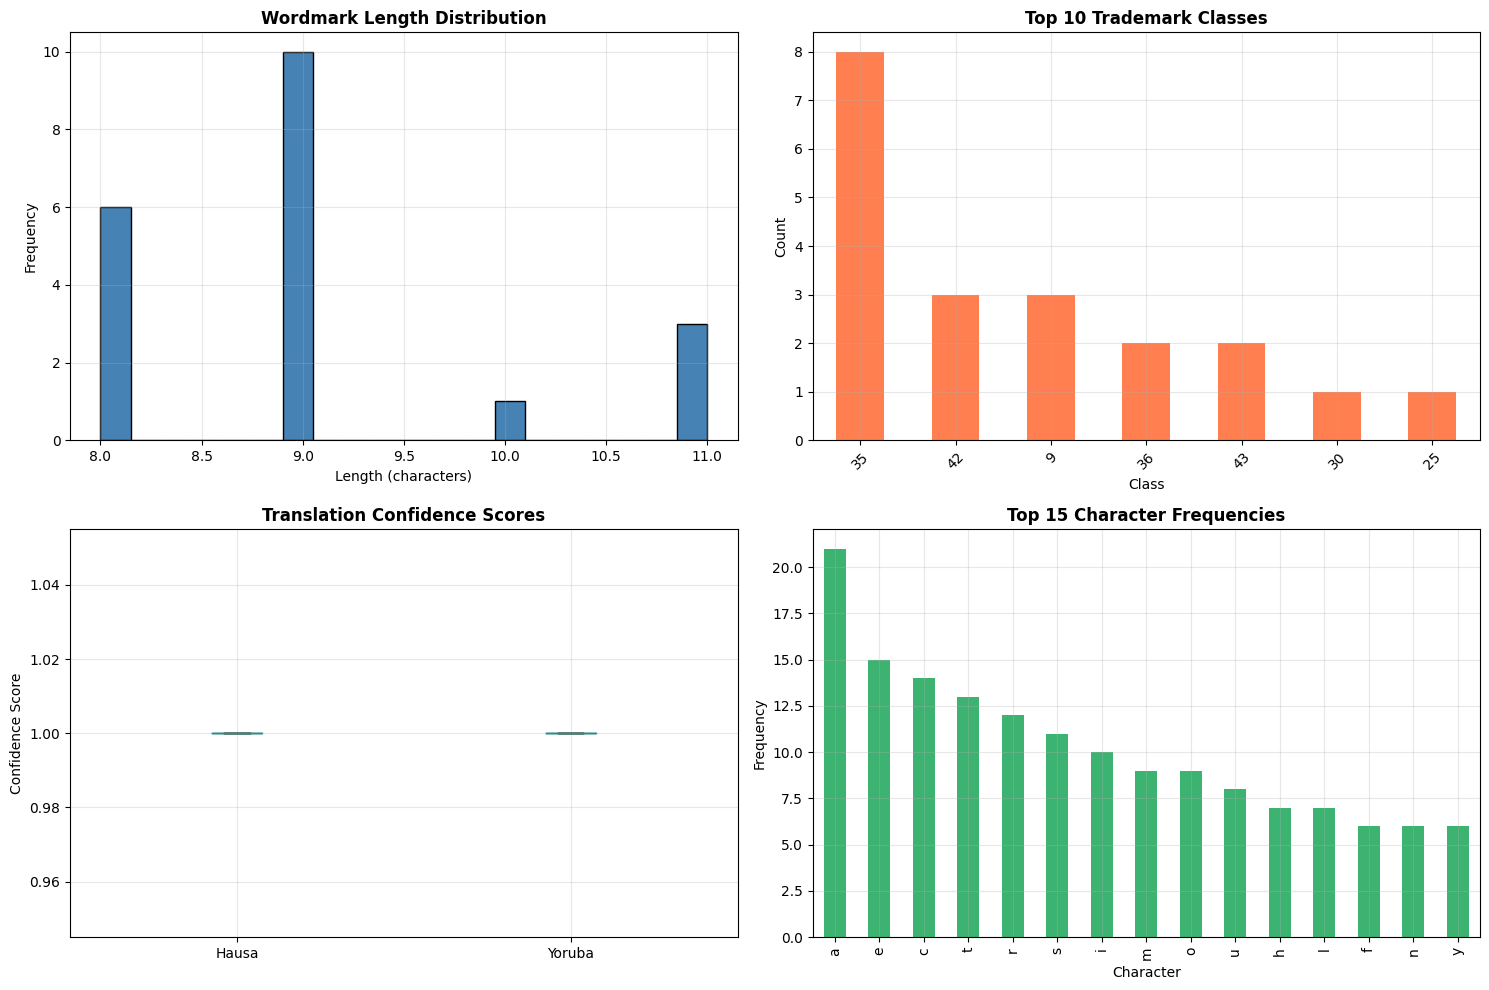


TRANSLATION QUALITY REPORT (Sample)
   original       hausa hausa_conf      yoruba yoruba_conf
   TechFlow    TechFlow      1.000    TechFlow       1.000
   DataSync    DataSync      1.000    DataSync       1.000
   SmartHub    SmartHub      1.000    SmartHub       1.000
  CyberLink   CyberLink      1.000   CyberLink       1.000
  CyberLinc   CyberLinc      1.000   CyberLinc       1.000
   QuickPay    QuickPay      1.000    QuickPay       1.000
   QuiccPay    QuiccPay      1.000    QuiccPay       1.000
  QuickMart   QuickMart      1.000   QuickMart       1.000
  QuiccMart   QuiccMart      1.000   QuiccMart       1.000
   FastShop    FastShop      1.000    FastShop       1.000
  MegaStore   MegaStore      1.000   MegaStore       1.000
  SuperMall   SuperMall      1.000   SuperMall       1.000
  FreshFood   FreshFood      1.000   FreshFood       1.000
  GoodTaste   GoodTaste      1.000   GoodTaste       1.000
PremiumCafe PremiumCafe      1.000 PremiumCafe       1.000
  StyleWear   Style

In [5]:
# Replace your current usage cell with this:

# Configure
config = TranslationConfig(
    translate_proper_nouns=False,
    preserve_brand_patterns=True
)

# Load and enhance
loader = TrademarkDataLoader(config)

try:
    # Try loading your actual file
    df = loader.load_data('trademark_file.csv')
    
    # Add translations
    print("\n🌍 Starting translation process...")
    df = loader.add_translations(['hausa', 'yoruba'])
    
    # Explore
    print("\n📊 Generating exploration report...")
    stats = loader.explore_data()
    
    # Translation report
    print("\n" + "=" * 80)
    print("TRANSLATION QUALITY REPORT (Sample)")
    print("=" * 80)
    translation_report = loader.get_translation_report(sample_size=20)
    print(translation_report.to_string(index=False))
    
    # Save enhanced dataset
    output_file = 'trademark_data_enhanced.csv'
    df.to_csv(output_file, index=False)
    print(f"\n✓ Enhanced dataset saved to {output_file}")
    print(f"  Columns: {list(df.columns)}")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    print("\nPlease check:")
    print("1. File 'trademark_file.csv' exists in the current directory")
    print("2. File has at least one column with trademark names")
    print("3. File is a valid CSV format")

In [7]:
!pip install chardet

  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
Using cached chardet-5.2.0-py3-none-any.whl (199 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet  # For encoding detection

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class PreprocessingConfig:
    """Configuration for preprocessing strategy"""
    fix_encoding: bool = True
    translate_to_english: bool = True
    translate_to_local: bool = True  # HA/YO
    remove_duplicates: bool = True
    handle_missing: str = 'drop'  # 'drop' or 'fill'


class BrazilianTrademarkPreprocessor:
    """
    Specialized preprocessor for Brazilian INPI trademark dataset
    Handles: Portuguese → English → Hausa/Yoruba translation pipeline
    """
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.original_df = None
        self.processed_df = None
        
        # Initialize translators
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.en_to_ha = GoogleTranslator(source='en', target='ha')
        self.en_to_yo = GoogleTranslator(source='en', target='yo')
        
        self.translation_cache = {}
    
    def detect_encoding(self, file_path: str) -> str:
        """
        Detect file encoding to fix those v� characters
        """
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))  # Read first 100KB
        
        detected = result['encoding']
        confidence = result['confidence']
        
        logger.info(f"Detected encoding: {detected} (confidence: {confidence:.2%})")
        return detected
    
    def load_and_fix_encoding(self, file_path: str) -> pd.DataFrame:
        """
        Load CSV with proper encoding detection and fixing
        """
        # Try to detect encoding
        try:
            encoding = self.detect_encoding(file_path)
        except Exception as e:
            logger.warning(f"Encoding detection failed: {e}. Trying latin-1...")
            encoding = 'latin-1'
        
        # Try loading with detected encoding
        encodings_to_try = [encoding, 'utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Successfully loaded with encoding: {enc}")
                self.original_df = df
                return df
            except Exception as e:
                logger.debug(f"Failed with {enc}: {e}")
                continue
        
        raise ValueError("Could not load CSV with any common encoding")
    
    def extract_relevant_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract and rename relevant columns from Brazilian dataset
        
        Original columns:
        - Process number RM, Name RM, Status RM, etc. (Registered Mark)
        - Process number TM, Name TM, Status TM, etc. (Target Mark - the contested one)
        """
        
        # Map to standardized column names
        column_mapping = {
            # Pair identification
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            
            # Wordmarks (the actual text)
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            
            # Status
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
            
            # Classification
            'Nice classification RM': 'mark1_class',
            'Nice classification TM': 'mark2_class',
            
            # Presentation (Nominative/Mixed/Figurative)
            'Presentation RM': 'mark1_presentation',
            'Presentation TM': 'mark2_presentation',
            
            # Date
            'Application date RM': 'mark1_date',
            'Application date TM': 'mark2_date',
            
            # Complementary text (explains why similar)
            'Complementary text': 'similarity_reason'
        }
        
        # Select and rename columns
        available_cols = [col for col in column_mapping.keys() if col in df.columns]
        df_processed = df[available_cols].copy()
        df_processed.rename(columns=column_mapping, inplace=True)
        
        # Add label: these pairs are SIMILAR (that's why they're in the rejection dataset)
        df_processed['label'] = 1  # 1 = similar/confusing
        
        logger.info(f"✓ Extracted {len(df_processed)} trademark pairs")
        logger.info(f"   Columns: {list(df_processed.columns)}")
        
        return df_processed
    
    def clean_text(self, text: str) -> str:
        """
        Clean trademark text
        - Remove extra whitespace
        - Fix common encoding artifacts
        - Normalize
        """
        if pd.isna(text) or text == '':
            return ''
        
        text = str(text)
        
        # Fix common encoding issues
        encoding_fixes = {
            'v�': 'ç',
            'v�o': 'ção',
            'v�': 'í',
            'v=': 'ó',
            '?': '',  # Remove question marks from encoding errors
        }
        
        for bad, good in encoding_fixes.items():
            text = text.replace(bad, good)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text.strip()
    
    def translate_with_cache(self, text: str, translator, cache_key: str) -> str:
        """
        Translate text with caching to avoid redundant API calls
        """
        if not text or text == '':
            return ''
        
        # Check cache
        cache_id = f"{cache_key}:{text}"
        if cache_id in self.translation_cache:
            return self.translation_cache[cache_id]
        
        # Translate
        try:
            translation = translator.translate(text)
            self.translation_cache[cache_id] = translation
            return translation
        except Exception as e:
            logger.warning(f"Translation failed for '{text[:50]}...': {e}")
            return text  # Return original on failure
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Translate wordmarks: Portuguese → English → Hausa/Yoruba
        """
        logger.info("🌍 Starting translation pipeline...")
        
        # Columns to translate
        wordmark_cols = ['mark1_wordmark', 'mark2_wordmark']
        
        for col in wordmark_cols:
            if col not in df.columns:
                continue
            
            logger.info(f"   Translating {col}...")
            
            # Portuguese → English
            if self.config.translate_to_english:
                en_col = col.replace('_wordmark', '_wordmark_en')
                df[en_col] = df[col].apply(
                    lambda x: self.translate_with_cache(
                        self.clean_text(x), 
                        self.pt_to_en, 
                        'pt_en'
                    )
                )
                logger.info(f"      ✓ Portuguese → English: {en_col}")
            
            # English → Hausa
            if self.config.translate_to_local:
                ha_col = col.replace('_wordmark', '_wordmark_ha')
                df[ha_col] = df[en_col].apply(
                    lambda x: self.translate_with_cache(
                        x, 
                        self.en_to_ha, 
                        'en_ha'
                    )
                )
                logger.info(f"      ✓ English → Hausa: {ha_col}")
                
                # English → Yoruba
                yo_col = col.replace('_wordmark', '_wordmark_yo')
                df[yo_col] = df[en_col].apply(
                    lambda x: self.translate_with_cache(
                        x, 
                        self.en_to_yo, 
                        'en_yo'
                    )
                )
                logger.info(f"      ✓ English → Yoruba: {yo_col}")
        
        return df
    
    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Handle missing values based on configuration
        """
        initial_count = len(df)
        
        if self.config.handle_missing == 'drop':
            # Drop rows where critical columns are missing
            critical_cols = ['mark1_wordmark', 'mark2_wordmark']
            df = df.dropna(subset=critical_cols)
            removed = initial_count - len(df)
            if removed > 0:
                logger.info(f"⚠ Removed {removed} rows with missing wordmarks")
        
        return df
    
    def remove_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Remove duplicate trademark pairs
        """
        if not self.config.remove_duplicates:
            return df
        
        initial_count = len(df)
        
        # Sort pairs to avoid (A,B) vs (B,A) duplicates
        df['pair_key'] = df.apply(
            lambda row: tuple(sorted([
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ])),
            axis=1
        )
        
        df = df.drop_duplicates(subset='pair_key')
        df = df.drop('pair_key', axis=1)
        
        removed = initial_count - len(df)
        if removed > 0:
            logger.info(f"⚠ Removed {removed} duplicate pairs")
        
        return df
    
    def add_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add basic features for later use
        """
        # Length features
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        
        # Same class indicator
        df['same_class'] = (df['mark1_class'] == df['mark2_class']).astype(int)
        
        # Length difference
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        
        return df
    
    def process(self, file_path: str) -> pd.DataFrame:
        """
        Full preprocessing pipeline
        """
        logger.info("=" * 80)
        logger.info("BRAZILIAN TRADEMARK DATASET PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load with encoding fix
        logger.info("\n1️⃣ Loading dataset...")
        df = self.load_and_fix_encoding(file_path)
        logger.info(f"   Loaded: {df.shape}")
        
        # 2. Extract relevant columns
        logger.info("\n2️⃣ Extracting relevant columns...")
        df = self.extract_relevant_columns(df)
        
        # 3. Clean text
        logger.info("\n3️⃣ Cleaning text...")
        for col in df.columns:
            if 'wordmark' in col or 'reason' in col:
                df[col] = df[col].apply(self.clean_text)
        
        # 4. Handle missing values
        logger.info("\n4️⃣ Handling missing values...")
        df = self.handle_missing_values(df)
        
        # 5. Remove duplicates
        logger.info("\n5️⃣ Removing duplicates...")
        df = self.remove_duplicates(df)
        
        # 6. Translate
        logger.info("\n6️⃣ Translating dataset...")
        df = self.translate_dataset(df)
        
        # 7. Add features
        logger.info("\n7️⃣ Adding features...")
        df = self.add_features(df)
        
        self.processed_df = df
        
        logger.info("\n" + "=" * 80)
        logger.info(f"✅ PREPROCESSING COMPLETE")
        logger.info(f"   Final dataset: {df.shape}")
        logger.info(f"   Columns: {list(df.columns)}")
        logger.info("=" * 80)
        
        return df
    
    def get_sample_report(self, n: int = 10) -> pd.DataFrame:
        """
        Get sample of processed data for inspection
        """
        if self.processed_df is None:
            raise ValueError("No processed data. Run process() first.")
        
        cols_to_show = [
            'mark1_wordmark', 'mark1_wordmark_en', 'mark1_wordmark_ha', 'mark1_wordmark_yo',
            'mark2_wordmark', 'mark2_wordmark_en', 'mark2_wordmark_ha', 'mark2_wordmark_yo',
            'label', 'same_class'
        ]
        
        available_cols = [col for col in cols_to_show if col in self.processed_df.columns]
        
        return self.processed_df[available_cols].head(n)
    
    def save_processed(self, output_path: str):
        """
        Save processed dataset
        """
        if self.processed_df is None:
            raise ValueError("No processed data to save")
        
        self.processed_df.to_csv(output_path, index=False, encoding='utf-8')
        logger.info(f"✅ Saved processed dataset to: {output_path}")


# ===========================
# USAGE
# ===========================

# Configure preprocessing
config = PreprocessingConfig(
    fix_encoding=True,
    translate_to_english=True,
    translate_to_local=True,  # Translate to HA/YO
    remove_duplicates=True,
    handle_missing='drop'
)

# Initialize preprocessor
preprocessor = BrazilianTrademarkPreprocessor(config)

# Process the dataset
try:
    processed_df = preprocessor.process('trademark_file.csv')
    
    # Show sample
    print("\n" + "=" * 80)
    print("SAMPLE PROCESSED DATA")
    print("=" * 80)
    sample = preprocessor.get_sample_report(n=5)
    print(sample.to_string())
    
    # Save processed dataset
    preprocessor.save_processed('trademark_data_processed_multilingual.csv')
    
    print("\n✅ Dataset ready for Step 1 (CNN + SVM training)")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

INFO:__main__:================================================================================
INFO:__main__:BRAZILIAN TRADEMARK DATASET PREPROCESSING
INFO:__main__:================================================================================
INFO:__main__:
1️⃣ Loading dataset...
INFO:__main__:Detected encoding: MacRoman (confidence: 72.30%)
INFO:__main__:✓ Successfully loaded with encoding: MacRoman
INFO:__main__:   Loaded: (18737, 18)
INFO:__main__:
2️⃣ Extracting relevant columns...
INFO:__main__:✓ Extracted 18737 trademark pairs
INFO:__main__:   Columns: ['mark1_id', 'mark2_id', 'mark1_wordmark', 'mark2_wordmark', 'mark1_status', 'mark2_status', 'mark1_class', 'mark2_class', 'mark1_presentation', 'mark2_presentation', 'mark1_date', 'mark2_date', 'similarity_reason', 'label']
INFO:__main__:
3️⃣ Cleaning text...
INFO:__main__:
4️⃣ Handling missing values...
INFO:__main__:
5️⃣ Removing duplicates...
INFO:__main__:⚠ Removed 3933 duplicate pairs
INFO:__main__:
6️⃣ Translating dataset

KeyboardInterrupt: 

In [11]:
##NEWWWWWWWWWWWWWWWWW
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet  # For encoding detection

# Add this near the top of your file (after imports)
TRADEMARK_LEXICON = {
    # English -> Hausa
    "coffee": {"ha": "kawo", "yo": "kofi"},
    "tea": {"ha": "shayi", "yo": "ti"},
    "brand": {"ha": "alama", "yo": "àmì"},
    "company": {"ha": "kamfani", "yo": "ọmọ ile-iṣẹ"},
    "original": {"ha": "na gaba", "yo": "àkọ́rí"},
    "premium": {"ha": "mai kyau", "yo": "píríḿíyọ̀mù"},
    "gold": {"ha": "zaki", "yo": "wùrà"},
    "silver": {"ha": "fari", "yo": "fùlùdù"},
    "king": {"ha": "sarki", "yo": "oba"},
    "queen": {"ha": "sarauniya", "yo": "iya oba"},
    "royal": {"ha": "sarki", "yo": "ọba"},
    "fresh": {"ha": "sabuwa", "yo": "tuntun"},
    "natural": {"ha": "ƙasa", "yo": "ọ̀dọ̀dọ̀"},
    "organic": {"ha": "mai alheri", "yo": "ọganik"},
    "classic": {"ha": "tsoho", "yo": "àkójọpọ̀"},
    "elite": {"ha": "masu hakuri", "yo": "àrìnàkò"},
    # Add more as needed...
}

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class PreprocessingConfig:
    """Configuration for preprocessing strategy"""
    fix_encoding: bool = True
    translate_to_english: bool = True
    translate_to_local: bool = True  # HA/YO
    remove_duplicates: bool = True
    handle_missing: str = 'drop'  # 'drop' or 'fill'
     # NEW: Sampling control
    max_rows: Optional[int] = None      # e.g., 1000 → process only 1000 rows
    sampling_strategy: str = 'first'    # 'first', 'random', or 'all'


class BrazilianTrademarkPreprocessor:
    """
    Specialized preprocessor for Brazilian INPI trademark dataset
    Handles: Portuguese → English → Hausa/Yoruba translation pipeline
    """
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.original_df = None
        self.processed_df = None
        
        # Initialize translators
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.en_to_ha = GoogleTranslator(source='en', target='ha')
        self.en_to_yo = GoogleTranslator(source='en', target='yo')
        
        self.translation_cache = {}
    
    def detect_encoding(self, file_path: str) -> str:
        """
        Detect file encoding to fix those v� characters
        """
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))  # Read first 100KB
        
        detected = result['encoding']
        confidence = result['confidence']
        
        logger.info(f"Detected encoding: {detected} (confidence: {confidence:.2%})")
        return detected
    
    def _get_lexicon_translation(self, word: str, target_lang: str) -> Optional[str]:
        """
        Get translation from domain lexicon (case-insensitive)
        target_lang: 'ha' or 'yo'
        """
        word_lower = word.lower().strip()
        if word_lower in TRADEMARK_LEXICON:
            return TRADEMARK_LEXICON[word_lower].get(target_lang)
        return None

    def translate_word_with_fallback(self, word: str, target_lang: str) -> str:
        """
        Translate a single word using lexicon first, then Google Translate
        """
        if not word or not word.strip():
            return word
        
        # 1. Try domain lexicon
        lex_trans = self._get_lexicon_translation(word, target_lang)
        if lex_trans:
            return lex_trans
        
        # 2. Fallback to Google Translate
        translator = self.en_to_ha if target_lang == 'ha' else self.en_to_yo
        cache_key = f"en_{target_lang}"
        return self.translate_with_cache(word, translator, cache_key)

    def translate_text_lexicon_first(self, text_en: str, target_lang: str) -> str:
        """
        Translate full text word-by-word using lexicon + fallback
        Preserves word order and handles multi-word terms crudely.
        """
        if pd.isna(text_en) or not text_en:
            return ""
        
        # Simple tokenization (you can improve with regex or NLP later)
        words = re.findall(r"\b\w+\b", str(text_en))
        translated_words = []
        
        for word in words:
            trans = self.translate_word_with_fallback(word, target_lang)
            translated_words.append(trans)
        
        return " ".join(translated_words)

    def load_and_fix_encoding(self, file_path: str) -> pd.DataFrame:
        """
        Load CSV with proper encoding detection and fixing
        """
        # Try to detect encoding
        try:
            encoding = self.detect_encoding(file_path)
        except Exception as e:
            logger.warning(f"Encoding detection failed: {e}. Trying latin-1...")
            encoding = 'latin-1'
        
        # Try loading with detected encoding
        encodings_to_try = [encoding, 'utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Successfully loaded with encoding: {enc}")
                self.original_df = df
                return df
            except Exception as e:
                logger.debug(f"Failed with {enc}: {e}")
                continue
        
        raise ValueError("Could not load CSV with any common encoding")
    
    def extract_relevant_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract and rename relevant columns from Brazilian dataset
        
        Original columns:
        - Process number RM, Name RM, Status RM, etc. (Registered Mark)
        - Process number TM, Name TM, Status TM, etc. (Target Mark - the contested one)
        """
        
        # Map to standardized column names
        column_mapping = {
            # Pair identification
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            
            # Wordmarks (the actual text)
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            
            # Status
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
            
            # Classification
            'Nice classification RM': 'mark1_class',
            'Nice classification TM': 'mark2_class',
            
            # Presentation (Nominative/Mixed/Figurative)
            'Presentation RM': 'mark1_presentation',
            'Presentation TM': 'mark2_presentation',
            
            # Date
            'Application date RM': 'mark1_date',
            'Application date TM': 'mark2_date',
            
            # Complementary text (explains why similar)
            'Complementary text': 'similarity_reason'
        }
        
        # Select and rename columns
        available_cols = [col for col in column_mapping.keys() if col in df.columns]
        df_processed = df[available_cols].copy()
        df_processed.rename(columns=column_mapping, inplace=True)
        
        # Add label: these pairs are SIMILAR (that's why they're in the rejection dataset)
        df_processed['label'] = 1  # 1 = similar/confusing
        
        logger.info(f"✓ Extracted {len(df_processed)} trademark pairs")
        logger.info(f"   Columns: {list(df_processed.columns)}")
        
        return df_processed
    
    def clean_text(self, text: str) -> str:
        """
        Clean trademark text
        - Remove extra whitespace
        - Fix common encoding artifacts
        - Normalize
        """
        if pd.isna(text) or text == '':
            return ''
        
        text = str(text)
        
        # Fix common encoding issues
        encoding_fixes = {
            'v�': 'ç',
            'v�o': 'ção',
            'v�': 'í',
            'v=': 'ó',
            '?': '',  # Remove question marks from encoding errors
        }
        
        for bad, good in encoding_fixes.items():
            text = text.replace(bad, good)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text.strip()
    
    def translate_with_cache(self, text: str, translator, cache_key: str) -> str:
        """
        Translate text with caching to avoid redundant API calls
        """
        if not text or text == '':
            return ''
        
        # Check cache
        cache_id = f"{cache_key}:{text}"
        if cache_id in self.translation_cache:
            return self.translation_cache[cache_id]
        
        # Translate
        try:
            translation = translator.translate(text)
            self.translation_cache[cache_id] = translation
            return translation
        except Exception as e:
            logger.warning(f"Translation failed for '{text[:50]}...': {e}")
            return text  # Return original on failure
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Translate wordmarks: Portuguese → English → [Hausa/Yoruba via lexicon + fallback]
        """
        logger.info("🌍 Starting translation pipeline...")
        
        wordmark_cols = ['mark1_wordmark', 'mark2_wordmark']
        
        for col in wordmark_cols:
            if col not in df.columns:
                continue
            
            logger.info(f"   Translating {col}...")
            
            # Portuguese → English (unchanged)
            if self.config.translate_to_english:
                en_col = col.replace('_wordmark', '_wordmark_en')
                df[en_col] = df[col].apply(
                    lambda x: self.translate_with_cache(
                        self.clean_text(x), 
                        self.pt_to_en, 
                        'pt_en'
                    )
                )
                logger.info(f"      ✓ Portuguese → English: {en_col}")
            
            # English → Hausa & Yoruba (enhanced)
            if self.config.translate_to_local:
                # Hausa
                ha_col = col.replace('_wordmark', '_wordmark_ha')
                df[ha_col] = df[en_col].apply(
                    lambda x: self.translate_text_lexicon_first(str(x), 'ha')
                )
                logger.info(f"      ✓ English → Hausa (lexicon+fallback): {ha_col}")
                
                # Yoruba
                yo_col = col.replace('_wordmark', '_wordmark_yo')
                df[yo_col] = df[en_col].apply(
                    lambda x: self.translate_text_lexicon_first(str(x), 'yo')
                )
                logger.info(f"      ✓ English → Yoruba (lexicon+fallback): {yo_col}")
        
        return df
    
    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Handle missing values based on configuration
        """
        initial_count = len(df)
        
        if self.config.handle_missing == 'drop':
            # Drop rows where critical columns are missing
            critical_cols = ['mark1_wordmark', 'mark2_wordmark']
            df = df.dropna(subset=critical_cols)
            removed = initial_count - len(df)
            if removed > 0:
                logger.info(f"⚠ Removed {removed} rows with missing wordmarks")
        
        return df
    
    def remove_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Remove duplicate trademark pairs
        """
        if not self.config.remove_duplicates:
            return df
        
        initial_count = len(df)
        
        # Sort pairs to avoid (A,B) vs (B,A) duplicates
        df['pair_key'] = df.apply(
            lambda row: tuple(sorted([
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ])),
            axis=1
        )
        
        df = df.drop_duplicates(subset='pair_key')
        df = df.drop('pair_key', axis=1)
        
        removed = initial_count - len(df)
        if removed > 0:
            logger.info(f"⚠ Removed {removed} duplicate pairs")
        
        return df
    
    def add_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add basic features for later use
        """
        # Length features
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        
        # Same class indicator
        df['same_class'] = (df['mark1_class'] == df['mark2_class']).astype(int)
        
        # Length difference
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        
        return df
    
    def _sample_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Sample the dataframe based on config: first N, random N, or all.
        Applied AFTER loading but BEFORE heavy processing (cleaning, translation).
        """

        if self.config.max_rows is not None and self.config.max_rows <= 0:
            raise ValueError("max_rows must be positive integer or None")
        
        if self.config.sampling_strategy == 'all' or self.config.max_rows is None:
            logger.info("📝 Sampling strategy: using all rows")
            return df

        n = min(self.config.max_rows, len(df))
        
        if self.config.sampling_strategy == 'first':
            sampled_df = df.head(n).copy()
            logger.info(f"📝 Sampling strategy: first {n} rows")
            
        elif self.config.sampling_strategy == 'random':
            sampled_df = df.sample(n=n, random_state=42).copy()  # reproducible
            logger.info(f"📝 Sampling strategy: random {n} rows (seed=42)")
            
        else:
            raise ValueError(f"Unknown sampling strategy: {self.config.sampling_strategy}")
        
        return sampled_df

    def process(self, file_path: str) -> pd.DataFrame:
        """
        Full preprocessing pipeline
        """
        logger.info("=" * 80)
        logger.info("BRAZILIAN TRADEMARK DATASET PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load with encoding fix
        logger.info("\n1️⃣ Loading dataset...")
        df = self.load_and_fix_encoding(file_path)
        logger.info(f"   Loaded: {df.shape}")
        
        # 2. Extract relevant columns
        logger.info("\n2️⃣ Extracting relevant columns...")
        df = self.extract_relevant_columns(df)
        
        # >>> NEW: Apply sampling here <<<
        logger.info("\n3️⃣ Applying sampling strategy...")
        df = self._sample_dataframe(df)
        logger.info(f"   After sampling: {df.shape}")

        # 3. Clean text
        logger.info("\n3️⃣ Cleaning text...")
        for col in df.columns:
            if 'wordmark' in col or 'reason' in col:
                df[col] = df[col].apply(self.clean_text)
        
        # 4. Handle missing values
        logger.info("\n4️⃣ Handling missing values...")
        df = self.handle_missing_values(df)
        
        # 5. Remove duplicates
        logger.info("\n5️⃣ Removing duplicates...")
        df = self.remove_duplicates(df)
        
        # 6. Translate
        logger.info("\n6️⃣ Translating dataset...")
        df = self.translate_dataset(df)
        
        # 7. Add features
        logger.info("\n7️⃣ Adding features...")
        df = self.add_features(df)
        
        self.processed_df = df
        
        logger.info("\n" + "=" * 80)
        logger.info(f"✅ PREPROCESSING COMPLETE")
        logger.info(f"   Final dataset: {df.shape}")
        logger.info(f"   Columns: {list(df.columns)}")
        logger.info("=" * 80)
        
        return df
    
    def get_sample_report(self, n: int = 10) -> pd.DataFrame:
        """
        Get sample of processed data for inspection
        """
        if self.processed_df is None:
            raise ValueError("No processed data. Run process() first.")
        
        cols_to_show = [
            'mark1_wordmark', 'mark1_wordmark_en', 'mark1_wordmark_ha', 'mark1_wordmark_yo',
            'mark2_wordmark', 'mark2_wordmark_en', 'mark2_wordmark_ha', 'mark2_wordmark_yo',
            'label', 'same_class'
        ]
        
        available_cols = [col for col in cols_to_show if col in self.processed_df.columns]
        
        return self.processed_df[available_cols].head(n)
    
    def save_processed(self, output_path: str):
        """
        Save processed dataset
        """
        if self.processed_df is None:
            raise ValueError("No processed data to save")
        
        self.processed_df.to_csv(output_path, index=False, encoding='utf-8')
        logger.info(f"✅ Saved processed dataset to: {output_path}")


# ===========================
# USAGE
# ===========================

# Configure preprocessing
config = PreprocessingConfig(
    max_rows=2,  # or omit (number or None)
    sampling_strategy='first', #['all', 'random', 'first']
    fix_encoding=True,
    translate_to_english=True,
    translate_to_local=True,  # Translate to HA/YO
    remove_duplicates=True,
    handle_missing='drop'
)

# Initialize preprocessor
preprocessor = BrazilianTrademarkPreprocessor(config)

# Process the dataset
try:
    processed_df = preprocessor.process('trademark_file.csv')
    
    # Show sample
    print("\n" + "=" * 80)
    print("SAMPLE PROCESSED DATA")
    print("=" * 80)
    sample = preprocessor.get_sample_report(n=5)
    print(sample.to_string())
    
    # Save processed dataset
    preprocessor.save_processed('trademark_data_processed_multilingual.csv')
    
    print("\n✅ Dataset ready for Step 1 (CNN + SVM training)")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

INFO:__main__:================================================================================
INFO:__main__:BRAZILIAN TRADEMARK DATASET PREPROCESSING
INFO:__main__:================================================================================
INFO:__main__:
1️⃣ Loading dataset...
INFO:__main__:Detected encoding: MacRoman (confidence: 72.30%)
INFO:__main__:✓ Successfully loaded with encoding: MacRoman
INFO:__main__:   Loaded: (18737, 18)
INFO:__main__:
2️⃣ Extracting relevant columns...
INFO:__main__:✓ Extracted 18737 trademark pairs
INFO:__main__:   Columns: ['mark1_id', 'mark2_id', 'mark1_wordmark', 'mark2_wordmark', 'mark1_status', 'mark2_status', 'mark1_class', 'mark2_class', 'mark1_presentation', 'mark2_presentation', 'mark1_date', 'mark2_date', 'similarity_reason', 'label']
INFO:__main__:
3️⃣ Applying sampling strategy...
INFO:__main__:📝 Sampling strategy: first 2 rows
INFO:__main__:   After sampling: (2, 14)
INFO:__main__:
3️⃣ Cleaning text...
INFO:__main__:
4️⃣ Handling missi


SAMPLE PROCESSED DATA
      mark1_wordmark mark1_wordmark_en mark1_wordmark_ha mark1_wordmark_yo mark2_wordmark mark2_wordmark_en mark2_wordmark_ha mark2_wordmark_yo  label  same_class
0            LeOffer           LeOffer           LeOffer           LeOffer     OFFER % TV         OFFER %TV         BAYANI TV          Ìfilọ TV      1           0
1  PADARIA MERCAPv…O  MERCAPv BAKERY…O  MERCAPv BAKERY O  MERCAPv BEKERE O      MERCOPv…O         MERCOPv…O         MERCOPv O         MERCOPv O      1           0

✅ Dataset ready for Step 1 (CNN + SVM training)
